# Blood Cell Detection and Classification
--- 

## 初始化

In [15]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.optim as optim
import torchvision
from torchvision.transforms import v2 as transforms

import os
import tqdm
import shutil
import xml.etree.ElementTree as ET

from tools import imagenette_dataset, train_model, evaluate_model
from models import Net, LeNet_5

下載資料集

In [16]:
if not os.path.exists('./blood-cells/'):
    path = kagglehub.dataset_download('paultimothymooney/blood-cells')
    print(f"Dataset downloaded to {path}")
    d = './blood-cells/'
    if os.path.isdir(path):
        shutil.copytree(path, d)
    print(f"Dataset setup completed.")
else:
    print("Dataset already exists.")

Dataset already exists.


In [17]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
	device = torch.device("cuda:0")
	print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
	device = torch.device("cpu")
	print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Classification

資料集設定

In [18]:
DATA_DIR = "./blood-cells/dataset2-master/dataset2-master/images/"

# Data transformations
data_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = imagenette_dataset(
    f"{DATA_DIR}/TRAIN", transform=data_transform)
val_dataset = imagenette_dataset(
    f"{DATA_DIR}/TEST_SIMPLE", transform=data_transform)
test_dataset = imagenette_dataset(
    f"{DATA_DIR}/TEST", transform=data_transform)

c:\Users\Win11P\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


載入資料

In [19]:
os_type = os.name
print("OS type:", os_type)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True,
    num_workers=4 if os_type == 'nt' else 0)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16,
    num_workers=4 if os_type == 'nt' else 0)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16,
    num_workers=4 if os_type == 'nt' else 0)

OS type: nt


資料樣本

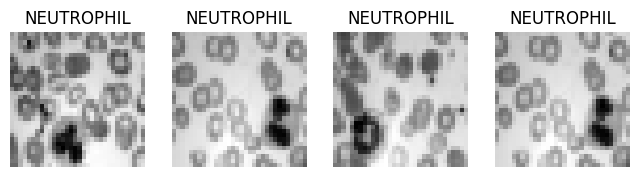

In [20]:
# Plot some samples
fig, axes = plt.subplots(1, 4, figsize=(8, 8))
for i in range(4):
    idx = np.random.randint(len(val_dataset))
    image, label = val_dataset[idx]
    label_name = val_dataset.idx_to_class[label]
    if image.shape[0] == 3:
        image = image.squeeze().permute(1, 2, 0)  # CxHxW to HxWxC for plotting
        cmap = None
    if image.shape[0] == 1:
        image = image.squeeze()  # HxW for grayscale images
        cmap = 'gray'
    axes[i].imshow(image, cmap=cmap)
    axes[i].set_title(f"{label_name}")
    axes[i].axis('off')
plt.show()

模型設定

In [21]:
# Instantiate the model
model = LeNet_5(input_size=32*32, output_classes=len(train_dataset.class_to_idx))
model = model.to(device)
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

LeNet_5(
  (cnn_model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=1024, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=4, bias=True)
  )
)


模型訓練

In [22]:
n_epochs = 20
pbar = tqdm.tqdm(total=n_epochs)
train_logs = []
val_logs = []
for epoch in range(n_epochs):
    # 1. Train the model for one epoch
    train_loss, train_accuracy = train_model(model, train_dataloader, optimizer, device)
    # 2. Evaluate the model on validation set
    val_loss, val_accuracy = evaluate_model(model, val_dataloader, device)
    # 3. Step the scheduler
    scheduler.step()
    
    train_logs.append((train_loss, train_accuracy))
    val_logs.append((val_loss, val_accuracy))
    pbar.set_description(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    pbar.update(1)
pbar.close()

Epoch 20/20, Train Loss: 1.3863, Train Accuracy: 0.2444, Val Loss: 1.3832, Val Accuracy: 0.6761: 100%|██████████| 20/20 [08:00<00:00, 24.02s/it]


儲存模型

In [23]:
MODEL_DIR = './model/'
torch.save(model.state_dict(), f'{MODEL_DIR}/LeNet-5_model.pth')
# del model

載入模型

In [24]:
model = LeNet_5(input_size=128*128, output_classes=len(train_dataset.class_to_idx))
model.load_state_dict(torch.load(f'{MODEL_DIR}/LeNet-5_model.pth'))
model = model.to(device)

輸出結果

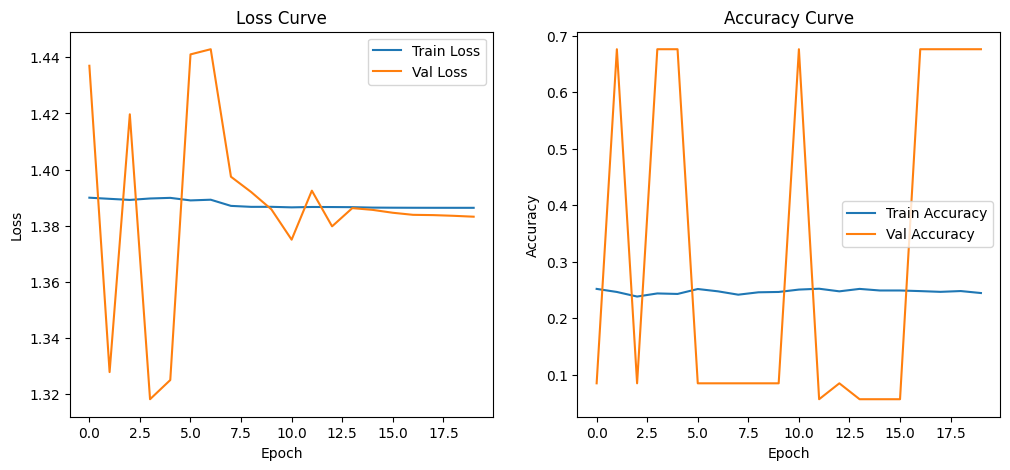

In [25]:
train_losses, train_accuracies = zip(*train_logs)
val_losses, val_accuracies = zip(*val_logs)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

## Detection

資料樣本

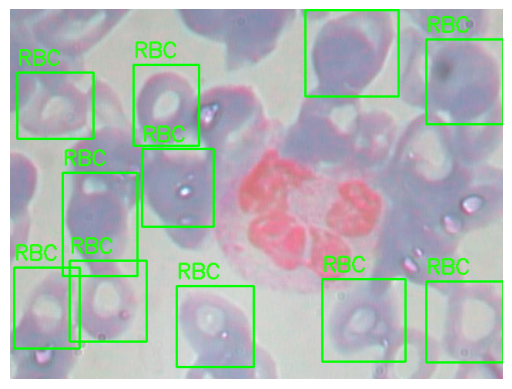

In [26]:
image_dir = './blood-cells/dataset-master/dataset-master/JPEGImages/'
annot_dir = './blood-cells/dataset-master/dataset-master/Annotations/'

image_index = '00000'
annotation_path = annot_dir + f'BloodImage_{image_index}.xml'
original_image_path = image_dir + f'BloodImage_{image_index}.jpg'

plt.axis('off')

# Original Image
img = cv2.imread(original_image_path)

# Draw Bounding Boxes
tree = ET.parse(annotation_path)
root = tree.getroot()
obj_count = len(root.findall('object'))
for obj in root.findall('object'):
    bbox = obj.find('bndbox')
    name = str(obj.find('name').text)
    xmin = int(bbox.find('xmin').text)
    ymin = int(bbox.find('ymin').text)
    xmax = int(bbox.find('xmax').text)
    ymax = int(bbox.find('ymax').text)
    cv2.putText(img, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

plt.imshow(img)